In [ ]:
import pandas as pd
import ast

# Load the dataset (First 1500 rows)
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\recipes_w_search_terms.csv").head(1500)

# Select only the desired columns
df = df[['id', 'ingredients', 'ingredients_raw_str']]

# Remove '%' symbol from 'ingredients' and 'ingredients_raw_str'
df['ingredients_raw_str'] = df['ingredients_raw_str'].str.replace('%', '', regex=True)
df['ingredients'] = df['ingredients'].str.replace('%', '', regex=True)

# Convert string representations of lists into actual lists
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(ast.literal_eval)

# Remove empty strings from lists
df['ingredients'] = df['ingredients'].apply(lambda x: [item.strip() for item in x if item.strip()])
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(lambda x: [item.strip() for item in x if item.strip()])

# Check for missing values
if df.isnull().sum().sum() > 0:
    print("Warning: There are missing values. Review dataset.")
else:
    print("No missing values detected!")

# Print sample output
print(df.head())

# Save the cleaned dataset
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset_2.csv", index=False)


In [3]:
import pandas as pd
import ast
import re
import unicodedata

# Load dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset_2.csv")

# Function to remove brackets and content inside them
def remove_brackets(ingredients_list):
    return [re.sub(r'\([^)]*\)', '', word) for word in ingredients_list]

# Function to remove accents from each word in a list
def remove_accents(ingredients_list):
    return [''.join(c for c in unicodedata.normalize('NFKD', word) if not unicodedata.combining(c)) for word in ingredients_list]

# Convert string representations to lists and lowercase
df['ingredients'] = df['ingredients'].str.lower().apply(ast.literal_eval)
df['ingredients_raw_str'] = df['ingredients_raw_str'].str.lower().apply(ast.literal_eval)


# Apply preprocessing: lowercase, remove brackets, lemmatize
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(remove_brackets).apply(remove_accents)
df['ingredients'] = df['ingredients'].apply(remove_brackets).apply(remove_accents)

# Save cleaned dataset
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset_2.csv", index=False)

# Print output
print(df.head())

       id                                        ingredients  \
0   96313  [water, grits, salt, cheddar cheese, garlic, o...   
1  232037  [onion, red bell pepper, garlic cloves, large ...   
2   41090  [white beans, canned black beans, tomatoes, on...   
3   60656  [zucchini, yellow squash, diced tomatoes, onio...   
4  232047  [beef stew meat, flour, salt, allspice, cinnam...   

                                 ingredients_raw_str  
0  [4   cups    water, 1   cup   uncooked old fas...  
1  [1   medium    onion, chopped coarse, 1   medi...  
2  [1   cup   canned white beans, rinsed and drai...  
3  [2       zucchini, sliced, 2   small    yellow...  
4  [3   lbs    beef stew meat, 3   tablespoons   ...  


In [38]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import ast

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset_2.csv")

#We make sure we have actual lists and not a full string
df['ingredients'] = df['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



# Load the model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to extract ingredients from a **batch** of quantity phrases
def llm_ingredient_extraction_batch(phrases):
    prompts = [
        f"I will give you a sentence with a quantity and an ingredient. I need to extract the ingredient from this sentence. Make sure that the ingredient extracted doesn’t contain any more information. From this sentence {phrase}, the ingredient is:"
        for phrase in phrases
    ]
    
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs)
    
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Function to process quantity phrases for a single row
def process_quantity_phrases(row):
    quantity_phrases = row['ingredients_raw_str']  # List of quantity phrases
    ingredients_in_recipe = row['ingredients']  # List of ground-truth ingredients
    
    # Extract all ingredients in **one batch**
    extracted_ingredients = llm_ingredient_extraction_batch(quantity_phrases)

    # Store results in a list, with each row containing ID, quantity phrase, extracted ingredient, and ground truth
    return [
        {
            "id": row['id'],
            "quantity_phrase": phrase,
            "extracted_ingredient": extracted,
            "ground_truth": truth
        }
        for phrase, extracted, truth in zip(quantity_phrases, extracted_ingredients, ingredients_in_recipe)
    ]

# Apply batch processing to each row
df['phrase_results'] = df.apply(process_quantity_phrases, axis=1)

# Expand results into a DataFrame
expanded_results = [
    result
    for _, row in df.iterrows()
    for result in row['phrase_results']
]

# Convert to a new DataFrame
detailed_df = pd.DataFrame(expanded_results)

# Save the detailed results to a CSV file
detailed_df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\post_lemmatized_extraction_food.com_2.csv", index=False)

# Print a preview of the results
print(detailed_df.head())

C:\Users\teore\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\teore\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


      id                       quantity_phrase extracted_ingredient  \
0  96313                     4   cups    water                water   
1  96313  1   cup   uncooked old fashion grits    old fashion grits   
2  96313                  1   teaspoon    salt                 salt   
3  96313  4   ounces   shredded cheddar cheese       cheddar cheese   
4  96313        1 -2   clove    garlic, minced         clove garlic   

     ground_truth  
0           water  
1           grits  
2            salt  
3  cheddar cheese  
4          garlic  


In [4]:
import pandas as pd
from Levenshtein import distance

def normalized_levenshtein_similarity(s1, s2):
    """Calculate normalized Levenshtein similarity between two strings."""
    max_len = max(len(s1), len(s2))
    if max_len == 0:  # Avoid division by zero
        return 1.0
    return 1 - distance(s1, s2) / max_len

def jaccard_similarity(s1, s2):
    """Calculate Jaccard similarity between two strings using tokenization."""
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)  # Common tokens
    union = len(set1 | set2)        # All unique tokens
    if union == 0:  # Avoid division by zero
        return 0.0
    return intersection / union

def flexible_similarity(ground_truth, extracted, jaccard_threshold=0.5, levenshtein_threshold=0.7):
    """
    Use Jaccard similarity for phrases and Levenshtein similarity for single words.
    
    Args:
        ground_truth (str): Ground truth ingredient.
        extracted (str): Extracted ingredient.
        jaccard_threshold (float): Threshold for Jaccard similarity.
        levenshtein_threshold (float): Threshold for Levenshtein similarity.
    
    Returns:
        str: 'Match' if similarity meets the appropriate threshold, else 'Mismatch'.
    """
    levenshtein_sim = normalized_levenshtein_similarity(ground_truth, extracted)
    
    if levenshtein_sim >= levenshtein_threshold:
        return 'Match'
    
    jaccard_sim = jaccard_similarity(ground_truth, extracted)
    
    if jaccard_sim >= jaccard_threshold:
        return 'Match'
    
    return 'Mismatch'

def double_check_mismatches(mismatches):
    double_checked_mismatches = []
    true_matches = []  # Variable to store true matches that were initially mismatches
    for recipeid, gt, extracted in mismatches:
        result = flexible_similarity(gt, extracted, jaccard_threshold=0.5, levenshtein_threshold=0.7)
        if result == 'Match':
            true_matches.append((recipeid, gt, extracted))  # Store true match in the true_matches list
        double_checked_mismatches.append((recipeid, gt, extracted, result))
    return double_checked_mismatches, true_matches

def match_percentage(matches, mismatches):
    total = len(matches) + len(mismatches)
    if total == 0:
        return 0
    return len(matches) / total * 100


def second_match_percentage(matches, mismatches, true_matches):
    """ Function to calculate the final percentage after double checking
    """
    length_mismatches = len(mismatches) - len(true_matches)
    length_matches = len(matches) + len(true_matches)
    total = length_mismatches + length_matches
    if total == 0:
        return 0
    return length_matches / total * 100

In [6]:
import pandas as pd
import os
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Function to lemmatize a list of words
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Function to remove brackets and content inside them
def remove_brackets(text):
    return re.sub(r"\[.*?\]|\(.*?\)", "", text)

# Function to remove accents from each word in a list
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    return ''.join(c for c in normalized_text if not unicodedata.combining(c))


# # Rename files for easier understanding (DO IT ONCE!)
# old_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\detailed_ingredient_comparison_lemmatized.csv"
# new_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\post_lemmatized_extraction_food.com.csv"
# os.rename(old_file_path, new_file_path)

df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\post_lemmatized_extraction_food.com_2.csv")

df['extracted_ingredient'] = df['extracted_ingredient'].apply(remove_accents).apply(remove_brackets).apply(lemmatize_words)
df['ground_truth'] = df['ground_truth'].apply(lemmatize_words)

# Convert the Dataframe into a variable for easier handling
recipe_id = df['id']
ground_truth = df['ground_truth']
ingredient_extracted = df['extracted_ingredient']


def match_checker_method_1(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (extracted == gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match




# FLAN T-5
recipe_id_1, matches_1, mismatches_1 = match_checker_method_1(recipe_id, ground_truth, ingredient_extracted)


def match_percentage(matches, mismatches):
    return len(matches)/(len(matches) + len(mismatches))


print("FLAN T-5")
print("Matches:", len(matches_1))
print("Mismatches:", len(mismatches_1))
print(match_percentage(matches_1, mismatches_1))
# print(mismatches_1)

FLAN T-5
Matches: 11378
Mismatches: 2863
0.7989607471385436


In [7]:
# Function to check elements element-by-element
def match_checker_method_2(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_2, matches_2, mismatches_2 = match_checker_method_2(recipe_id, ground_truth, ingredient_extracted)

print("Matches:", len(matches_2))
print("Mismatches:", len(mismatches_2))
print(match_percentage(matches_2, mismatches_2))

Matches: 13678
Mismatches: 563
0.9604662593918967


In [8]:
# Function to check elements element-by-element
def match_checker_method_3(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (gt in extracted):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match


#FLAN T-5 results
recipe_id_3, matches_3, mismatches_3 = match_checker_method_3(recipe_id, ground_truth, ingredient_extracted)
def match_percentage(matches, mismatches):
    return len(matches)/len(matches + mismatches) 

print("Matches:", len(matches_3))
print("Mismatches:", len(mismatches_3))
print(match_percentage(matches_3, mismatches_3))

Matches: 11656
Mismatches: 2585
0.8184818481848185


In [9]:
# Function to check elements element-by-element
def match_checker_method_4(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (gt in extracted) or (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_4, matches_4, mismatches_4 = match_checker_method_4(recipe_id, ground_truth, ingredient_extracted)

# Double check mismatches using flexible_similarity
double_checked_mismatches, true_matches = double_check_mismatches(mismatches_4)

print("Matches:", len(matches_4))
print("Mismatches:", len(mismatches_4))
print(match_percentage(matches_4, mismatches_4))
# print(mismatches_4)

Matches: 13956
Mismatches: 285
0.9799873604381715


In [10]:
# Second Phase Results
final_results_4 = second_match_percentage(matches_4, mismatches_4, true_matches)
print("Second Phase Matches:", final_results_4)

# New variables for updated listof matches and mismatches
new_mismatches_4 = []
for mismatch in mismatches_4:
    if mismatch not in true_matches:
        new_mismatches_4.append(mismatch)
# New variable for updated matches
new_matches_4 = matches_4 + true_matches 

Second Phase Matches: 98.5113404957517


# Statistical Functions (Old Matches)

Method 1:       recipeID  MatchPercentage
0           39        88.461538
1          169        62.500000
2          355       100.000000
3          360        63.636364
4          503        93.750000
...        ...              ...
1495    533858        55.555556
1496    533943        77.777778
1497    534806        75.000000
1498    534857        94.444444
1499    537031       100.000000

[1500 rows x 2 columns]
Method 2:       recipeID  MatchPercentage
0           39        96.153846
1          169       100.000000
2          355       100.000000
3          360       100.000000
4          503       100.000000
...        ...              ...
1495    533858        88.888889
1496    533943        88.888889
1497    534806       100.000000
1498    534857       100.000000
1499    537031       100.000000

[1500 rows x 2 columns]
Method 3:       recipeID  MatchPercentage
0           39        88.461538
1          169        62.500000
2          355       100.000000
3          360        63

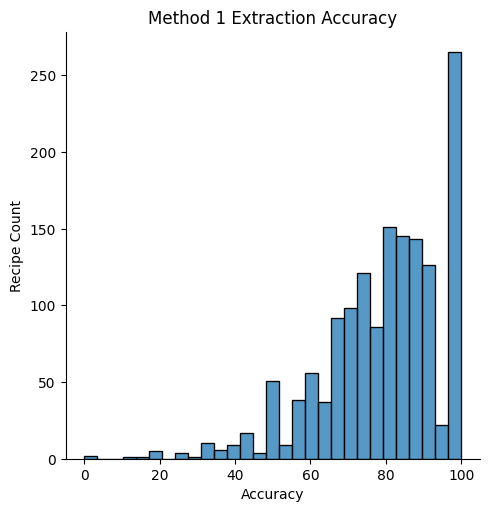

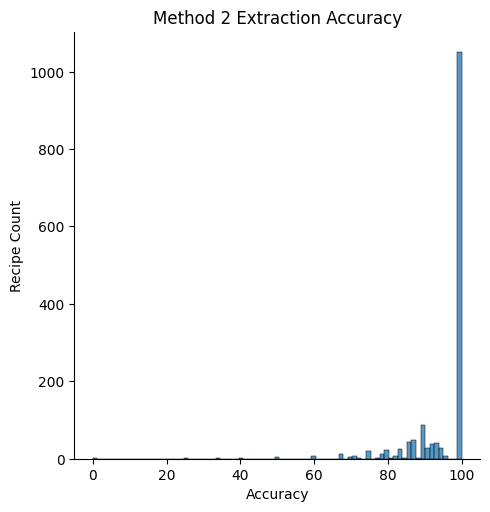

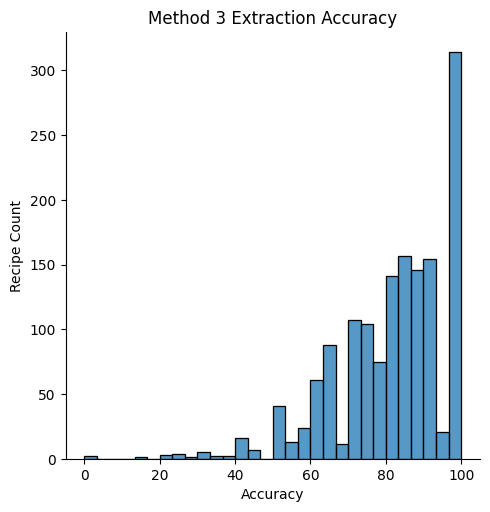

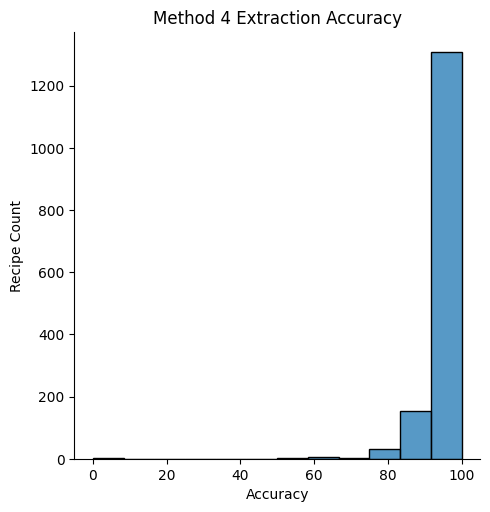

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionaries to store match percentages per recipeID
match_percentage_per_recipe_m_1 = {}
match_percentage_per_recipe_m_2 = {}
match_percentage_per_recipe_m_3 = {}
match_percentage_per_recipe_m_4 = {}

# Group by `recipeID` and apply matching functions
for recipe_id, row in df.groupby('id'):
    ingredients_gt_per_id = row['ground_truth'].tolist()
    ingredients_extracted_per_id = row['extracted_ingredient'].tolist()

    # Apply match checking functions
    _, matches_per_id_1, mismatches_per_id_1 = match_checker_method_1(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_2, mismatches_per_id_2 = match_checker_method_2(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_3, mismatches_per_id_3 = match_checker_method_3(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_4, mismatches_per_id_4 = match_checker_method_4(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    
    # Use match_percentage function to calculate and store match percentages
    match_percentage_per_recipe_m_1[recipe_id] = match_percentage(matches_per_id_1, mismatches_per_id_1) * 100
    match_percentage_per_recipe_m_2[recipe_id] = match_percentage(matches_per_id_2, mismatches_per_id_2) * 100
    match_percentage_per_recipe_m_3[recipe_id] = match_percentage(matches_per_id_3, mismatches_per_id_3) * 100
    match_percentage_per_recipe_m_4[recipe_id] = match_percentage(matches_per_id_4, mismatches_per_id_4) * 100

    
# Convert the results into DataFrames for easier handling
recipe_percentage_1 = pd.DataFrame(list(match_percentage_per_recipe_m_1.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_2 = pd.DataFrame(list(match_percentage_per_recipe_m_2.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_3 = pd.DataFrame(list(match_percentage_per_recipe_m_3.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_4 = pd.DataFrame(list(match_percentage_per_recipe_m_4.items()), columns=['recipeID', 'MatchPercentage'])

# Display results
print('Method 1:', recipe_percentage_1)
print('Method 2:', recipe_percentage_2)
print('Method 3:', recipe_percentage_3)
print('Method 4:', recipe_percentage_4)

# Calculate and display the average match percentage for each method
average_m_1 = recipe_percentage_1['MatchPercentage'].mean()
average_m_2 = recipe_percentage_2['MatchPercentage'].mean()
average_m_3 = recipe_percentage_3['MatchPercentage'].mean()
average_m_4 = recipe_percentage_4['MatchPercentage'].mean()

print(f'Average Match Percentage for Method 1: {average_m_1:.3f}%')
print(f'Average Match Percentage for Method 2: {average_m_2:.3f}%')
print(f'Average Match Percentage for Method 3: {average_m_3:.3f}%')
print(f'Average Match Percentage for Method 4: {average_m_4:.3f}%')

# Standard Deviation
print('Standard Deviation for Method 1:', recipe_percentage_1['MatchPercentage'].std())
print('Standard Deviation for Method 2:', recipe_percentage_2['MatchPercentage'].std())
print('Standard Deviation for Method 3:', recipe_percentage_3['MatchPercentage'].std())
print('Standard Deviation for Method 4:', recipe_percentage_4['MatchPercentage'].std())

# Max and Min
print('\nMax Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].max())
print('Min Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].min())
print('Max Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].max())
print('Min Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].min())
print('Max Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].max())
print('Min Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].min())
print('Max Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].max())
print('Min Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].min())




# Plot Histograms
for i, df in enumerate([recipe_percentage_1, recipe_percentage_2, recipe_percentage_3, recipe_percentage_4], start=1):
    sns.displot(data=df, x="MatchPercentage")
    plt.xlabel("Accuracy")
    plt.ylabel("Recipe Count")
    plt.title(f'Method {i} Extraction Accuracy')
    
    plt.savefig(f"Method_{i}_extraction_accuracy_food.com.png", bbox_inches='tight')
    
    plt.show()


# statistical Functions (Checked Loose)

Updated Match Percentages by Recipe:       recipeID  MatchPercentage
0           39        96.153846
1          169       100.000000
2          355       100.000000
3          360       100.000000
4          503       100.000000
...        ...              ...
1495    533858       100.000000
1496    533943       100.000000
1497    534806       100.000000
1498    534857       100.000000
1499    537031       100.000000

[1500 rows x 2 columns]

Average Match Percentage: 98.33%
Standard Deviation: 5.89
Max Match Percentage: 100.00%
Min Match Percentage: 0.00%


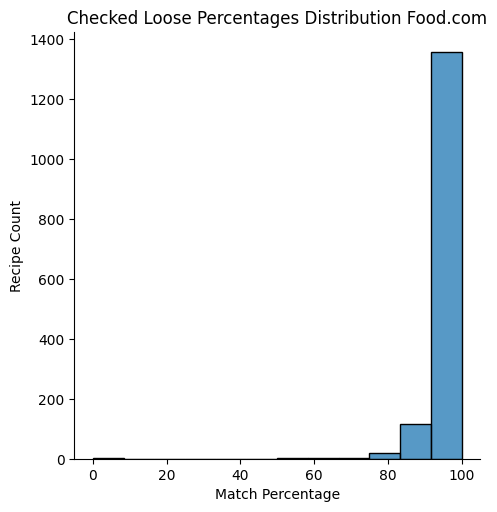

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for new matches and mismatches
new_matches_df = pd.DataFrame(
    new_matches_4, columns=['id', 'ground_truth', 'extracted_ingredient']
).assign(status='Match')  # Label as matches

new_mismatches_df = pd.DataFrame(
    new_mismatches_4, columns=['id', 'ground_truth', 'extracted_ingredient']
).assign(status='Mismatch')  # Label as mismatches

# Combine the new matches and mismatches into one DataFrame
updated_df = pd.concat([new_matches_df, new_mismatches_df], ignore_index=True)

# Initialize a dictionary to store match percentages
updated_match_percentage = {}

# Group by `recipeID` and calculate match percentages
for recipe_id, group in updated_df.groupby('id'):
    matches_per_id = group[group['status'] == 'Match']
    mismatches_per_id = group[group['status'] == 'Mismatch']
    
    # Calculate match percentage
    total_count = len(matches_per_id) + len(mismatches_per_id)
    if total_count > 0:
        updated_match_percentage[recipe_id] = (len(matches_per_id) / total_count) * 100
    else:
        updated_match_percentage[recipe_id] = 0  # No matches or mismatches

# Convert the match percentages into a DataFrame
updated_recipe_percentage = pd.DataFrame(
    list(updated_match_percentage.items()), columns=['recipeID', 'MatchPercentage']
)

# Display insights for the updated matches
print('Updated Match Percentages by Recipe:', updated_recipe_percentage)

# Calculate and display overall statistics
average_match_percentage = updated_recipe_percentage['MatchPercentage'].mean()
std_match_percentage = updated_recipe_percentage['MatchPercentage'].std()
max_match_percentage = updated_recipe_percentage['MatchPercentage'].max()
min_match_percentage = updated_recipe_percentage['MatchPercentage'].min()

print(f'\nAverage Match Percentage: {average_match_percentage:.2f}%')
print(f'Standard Deviation: {std_match_percentage:.2f}')
print(f'Max Match Percentage: {max_match_percentage:.2f}%')
print(f'Min Match Percentage: {min_match_percentage:.2f}%')

# Plot a histogram for the updated match percentages
sns.displot(data=updated_recipe_percentage, x="MatchPercentage", kde=False)
plt.xlabel("Match Percentage")
plt.ylabel("Recipe Count")
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\food.com_percentage_distribution_checked_loose.png")
plt.title("Checked Loose Percentages Distribution Food.com")
plt.show()


# Divide into bins (Old)

In [53]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to categorize match percentages into bins
# def categorize_into_bins(match_percentage):
#     if match_percentage == 100:
#         return "100%"
#     elif 95 <= match_percentage < 100:
#         return "95%-99%"
#     elif 90 <= match_percentage < 95:
#         return "90%-94%"
#     elif 85 <= match_percentage < 90:
#         return "85%-89%"
#     elif 80 <= match_percentage < 85:
#         return "80%-84%"
#     else:
#         return "Below 80%"

# # Apply categorization for each method
# bins_1 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_1.values()]
# bins_2 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_2.values()]
# bins_3 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_3.values()]
# bins_4 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_4.values()]

# # Create DataFrames to store frequency distribution
# frequency_df_1 = pd.DataFrame(bins_1, columns=['Match Percentage Range'])
# frequency_df_2 = pd.DataFrame(bins_2, columns=['Match Percentage Range'])
# frequency_df_3 = pd.DataFrame(bins_3, columns=['Match Percentage Range'])
# frequency_df_4 = pd.DataFrame(bins_4, columns=['Match Percentage Range'])

# # Get the frequency distribution for each method
# frequency_distribution_1 = frequency_df_1['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_2 = frequency_df_2['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_3 = frequency_df_3['Match Percentage Range'].value_counts().sort_index()
# frequency_distribution_4 = frequency_df_4['Match Percentage Range'].value_counts().sort_index()

# # Print frequency distributions
# print(f'Frequency Distribution for Method 1:\n{frequency_distribution_1}')
# print(f'Frequency Distribution for Method 2:\n{frequency_distribution_2}')
# print(f'Frequency Distribution for Method 3:\n{frequency_distribution_3}')
# print(f'Frequency Distribution for Method 4:\n{frequency_distribution_4}')

# # Optionally, plot the distributions
# for i, distribution in enumerate([frequency_distribution_1, frequency_distribution_2, frequency_distribution_3, frequency_distribution_4], start=1):
#     distribution.plot(kind='bar', title=f'Method {i} Frequency Distribution')
#     plt.xlabel("Match Percentage Range")
#     plt.ylabel("Number of Recipes")
#     plt.xticks(rotation=45)
#     plt.show()
#     plt.tight_layout()  # Adjust layout to prevent label overlap
#     #Save the figure before showing it
#     plt.savefig(f"Method_{i}_Frequency_Distribution_Dataset2.png", bbox_inches='tight')
    
#     # Optionally, show the plot
#     plt.show()
    
#     # Close the plot to avoid issues with subsequent figures
#     plt.close()


In [54]:
# #Find out the recipes that have an average lower than 50% for string matching
# print('Method 1:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_1.items():
#     if percentage < 40:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nExtracted within GT method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_2.items():
#     if percentage < 50:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nGT within Extracted method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_3.items():
#     if percentage < 70:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
# #Find out the recipes that have an average lower than 50% for string matching
# print('\nWithin either column method:\n')
# for recipeid, percentage in match_percentage_per_recipe_m_4.items():
#     if percentage < 75:
#         print('recipeID:', recipeid, 'Percentage:', percentage)
    
    

# Divide into bins (New)

In [55]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to categorize match percentages into bins
# def categorize_into_bins(match_percentage):
#     if match_percentage == 100:
#         # return "100%"
#     elif 95 <= match_percentage < 100:
#         return "95%-99%"
#     elif 90 <= match_percentage < 95:
#         return "90%-94%"
#     elif 85 <= match_percentage < 90:
#         return "85%-89%"
#     elif 80 <= match_percentage < 85:
#         return "80%-84%"
#     else:
#         return "Below 80%"

# # Apply categorization to the updated match percentages
# bins_updated = [categorize_into_bins(m) for m in updated_match_percentage.values()]

# # Create a DataFrame for frequency distribution
# frequency_df_updated = pd.DataFrame(bins_updated, columns=['Match Percentage Range'])

# # Get the frequency distribution
# frequency_distribution_updated = frequency_df_updated['Match Percentage Range'].value_counts().sort_index()

# # Print frequency distribution
# print(f'Frequency Distribution for Updated Dataset:\n{frequency_distribution_updated}')

# # Plot the distribution
# frequency_distribution_updated.plot(kind='bar', title='Frequency Distribution for Updated Dataset')
# plt.xlabel("Match Percentage Range")
# plt.ylabel("Number of Recipes")
# plt.xticks(rotation=45)
# plt.tight_layout()  # Adjust layout to prevent label overlap

# # Save the figure
# plt.savefig("Updated_Frequency_Distribution_Dataset2.png", bbox_inches='tight')

# # Show the plot
# plt.show()

# # Close the plot to avoid issues with subsequent figures
# plt.close()
